In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
import joblib
import torch
import random
from joblib import dump, load

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


# <h1>Load dữ liệu file</h1>

In [211]:
df = pd.read_excel('data/Electrical_2021_2024.xlsx', sheet_name="Data tổng" , header = 0)
df.head(10)

,Ngày,Thứ,Value,Miss Value
0,2021-01-01,Friday,136237245.0,NaN
1,2021-01-02,Saturday,160602211.0,NaN
2,2021-01-03,Sunday,163564033.0,NaN
3,2021-01-04,Monday,207504875.0,NaN
4,2021-01-05,Tuesday,219632846.0,NaN
5,2021-01-06,Wednesday,220423431.0,NaN
6,2021-01-07,Thursday,219802350.0,NaN
7,2021-01-08,Friday,220488686.0,NaN
8,2021-01-09,Saturday,209284611.0,NaN
9,2021-01-10,Sunday,173704316.0,NaN


# <h1>Tiền xử lý dữ liệu</h1>

In [212]:
def label_encode_columns(df, columns_to_encode):
    label_encoders = {}
    for column in columns_to_encode:
        # Chuyển đổi cột thành chuỗi nếu cần
        df[column] = df[column].astype(str)
        
        # Áp dụng LabelEncoder
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        
        # Lưu lại đối tượng LabelEncoder để sử dụng sau này
        label_encoders[column] = label_encoder
        
        # Lưu model encoder vào file
        joblib.dump(label_encoder, f'label_encoder/{column}_labelencoder.pkl')
    
    return df, label_encoders

In [213]:
# # Các cột cần Label Encode
# columns_to_encode = ['Thứ']
# # Thực hiện Label Encoding
# df, label_encoders = label_encode_columns(df, columns_to_encode)

In [214]:
day_mapping = {day: idx for idx, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}
df['Thứ'] = df['Thứ'].map(day_mapping)

In [215]:
# Lưu ánh xạ vào file
dump(day_mapping, 'model/day_mapping.joblib')
print(df)

           Ngày  Thứ         Value  Miss Value
0    2021-01-01    4  1.362372e+08         NaN
1    2021-01-02    5  1.606022e+08         NaN
2    2021-01-03    6  1.635640e+08         NaN
3    2021-01-04    0  2.075049e+08         NaN
4    2021-01-05    1  2.196328e+08         NaN
...         ...  ...           ...         ...
1364 2024-09-26    3  2.670000e+08         NaN
1365 2024-09-27    4  2.665344e+08         NaN
1366 2024-09-28    5  2.519644e+08         NaN
1367 2024-09-29    6  2.115458e+08         NaN
1368 2024-09-30    0  2.475014e+08         NaN

[1369 rows x 4 columns]


In [216]:
# Chuyển cột "Ngày" thành kiểu datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

In [217]:
# Tạo biểu đồ
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['Ngày'], y=df['Value'], mode='lines', name='Giá trị'))

# Cài đặt tiêu đề và nhãn
fig.update_layout(
    title='Biểu đồ Time Series',
    xaxis_title='Ngày',
    yaxis_title='Giá trị',
    xaxis_rangeslider_visible=True
)

# Hiển thị biểu đồ
fig.show()

In [218]:
df = df.drop(columns=['Miss Value'], errors='ignore')

In [219]:
def show_infor_dataframe(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Column '{column}' has {len(unique_values)} unique values:")
        print(unique_values)
        print("\n")

In [220]:
show_infor_dataframe(df)

Column 'Ngày' has 1369 unique values:
<DatetimeArray>
['2021-01-01 00:00:00', '2021-01-02 00:00:00', '2021-01-03 00:00:00',
 '2021-01-04 00:00:00', '2021-01-05 00:00:00', '2021-01-06 00:00:00',
 '2021-01-07 00:00:00', '2021-01-08 00:00:00', '2021-01-09 00:00:00',
 '2021-01-10 00:00:00',
 ...
 '2024-09-21 00:00:00', '2024-09-22 00:00:00', '2024-09-23 00:00:00',
 '2024-09-24 00:00:00', '2024-09-25 00:00:00', '2024-09-26 00:00:00',
 '2024-09-27 00:00:00', '2024-09-28 00:00:00', '2024-09-29 00:00:00',
 '2024-09-30 00:00:00']
Length: 1369, dtype: datetime64[ns]


Column 'Thứ' has 7 unique values:
[4 5 6 0 1 2 3]


Column 'Value' has 1226 unique values:
[1.36237245e+08 1.60602211e+08 1.63564033e+08 ... 2.51964447e+08
 2.11545848e+08 2.47501424e+08]




In [221]:
print(df.isnull().sum())

Ngày      0
Thứ       0
Value    23
dtype: int64


In [222]:
# Tính giá trị trung bình cho từng ngày trong tuần
avg_by_weekday = df.groupby('Thứ')['Value'].transform('mean')

# Điền giá trị thiếu bằng trung bình của ngày trong tuần
df['Value'] = df['Value'].fillna(avg_by_weekday)
df['Value'] = df['Value'].round().astype(int)


*Thêm dữ liệu ngày nghỉ lễ*

In [223]:

# Danh sách ngày nghỉ lễ (từ năm 2021 đến năm 2024)
public_holidays = [
    # Năm 2021
    '2021-01-01',  # Tết Dương lịch
    '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14',  # Tết Nguyên Đán
    '2021-04-21',  # Giỗ Tổ Hùng Vương
    '2021-04-30',  # Ngày Giải phóng miền Nam
    '2021-05-01',  # Quốc tế Lao động
    '2021-09-02',  # Quốc Khánh
    # Năm 2022
    '2022-01-01',  # Tết Dương lịch
    '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04',  # Tết Nguyên Đán
    '2022-04-10',  # Giỗ Tổ Hùng Vương
    '2022-04-30',  # Ngày Giải phóng miền Nam
    '2022-05-01',  # Quốc tế Lao động
    '2022-09-02',  # Quốc Khánh
    # Năm 2023
    '2023-01-01',  # Tết Dương lịch
    '2023-01-20', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26',  # Tết Nguyên Đán
    '2023-04-29',  # Giỗ Tổ Hùng Vương
    '2023-04-30',  # Ngày Giải phóng miền Nam
    '2023-05-01',  # Quốc tế Lao động
    '2023-09-02',  # Quốc Khánh
    # Năm 2024
    '2024-01-01',  # Tết Dương lịch
    '2024-02-08', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12',  # Tết Nguyên Đán
    '2024-04-10',  # Giỗ Tổ Hùng Vương
    '2024-04-30',  # Ngày Giải phóng miền Nam
    '2024-05-01',  # Quốc tế Lao động
    '2024-09-02'   # Quốc Khánh
]

# Chuyển đổi chuỗi thành định dạng datetime
public_holidays = pd.to_datetime(public_holidays)

# Thêm cột 'day off': 1 nếu là ngày nghỉ, 0 nếu không phải
df['day off'] = np.where((df['Ngày'].isin(public_holidays)) | (df['Thứ'].isin([2, 3])), 1, 0)


In [224]:
# Thêm đặc trưng phân biệt các loại ngày nghỉ
df['national_holiday'] = np.where(df['Ngày'].isin(public_holidays), 1, 0)
df['weekend'] = np.where(df['Thứ'].isin([5, 6]), 1, 0)  # 6, 7 là Thứ Bảy, Chủ Nhật

# Thêm ngày trước và sau ngày lễ
df['before_holiday'] = np.where(df['Ngày'].shift(-1).isin(public_holidays), 1, 0)
df['after_holiday'] = np.where(df['Ngày'].shift(1).isin(public_holidays), 1, 0)

# Đánh dấu toàn bộ chuỗi các ngày lễ liên tiếp
TET_dates = ['2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14', 
             '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02',
             '2023-01-20', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26',
             '2024-02-08', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12']
TET_dates = pd.to_datetime(TET_dates)
df['tet_holiday'] = np.where(df['Ngày'].isin(TET_dates), 1, 0)


In [225]:
df

,Ngày,Thứ,Value,day off,national_holiday,weekend,before_holiday,after_holiday,tet_holiday
0,2021-01-01,4,136237245,1,1,0,0,0,0
1,2021-01-02,5,160602211,0,0,1,0,1,0
2,2021-01-03,6,163564033,0,0,1,0,0,0
3,2021-01-04,0,207504875,0,0,0,0,0,0
4,2021-01-05,1,219632846,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1364,2024-09-26,3,266999959,1,0,0,0,0,0
1365,2024-09-27,4,266534447,0,0,0,0,0,0
1366,2024-09-28,5,251964447,0,0,1,0,0,0
1367,2024-09-29,6,211545848,0,0,1,0,0,0


*Thêm dữ liệu nhiệt độ*

In [226]:
df_temp = pd.read_csv('data/temperature.csv', header = 0)
df_temp.head(10)

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-01-01,25.1,23.0,30.0,NaN,NaN,28,11.8,NaN,1011.3,NaN
1,2021-01-02,26.2,22.0,31.0,NaN,NaN,3,10.2,NaN,1010.5,NaN
2,2021-01-03,27.3,22.0,32.0,NaN,NaN,357,6.8,NaN,1009.8,NaN
3,2021-01-04,27.8,24.0,33.0,NaN,NaN,39,7.7,NaN,1009.4,NaN
4,2021-01-05,27.6,24.0,32.0,NaN,NaN,31,6.4,NaN,1009.8,NaN
5,2021-01-06,28.1,24.0,32.0,NaN,NaN,71,7.3,NaN,1008.8,NaN
6,2021-01-07,28.1,24.0,34.0,NaN,NaN,57,7.1,NaN,1008.3,NaN
7,2021-01-08,27.6,24.0,33.0,NaN,NaN,355,5.9,NaN,1008.2,NaN
8,2021-01-09,26.9,23.0,32.0,NaN,NaN,37,7.1,NaN,1009.3,NaN
9,2021-01-10,26.1,22.0,30.0,NaN,NaN,351,6.4,NaN,1010.0,NaN


In [227]:
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y-%m-%d')
df_final = pd.merge(df, df_temp[['date','tavg', 'tmin', 'tmax']], left_on='Ngày', right_on='date', how='left')

df_final.drop(columns=['date'], inplace=True)
df_final.rename(columns={'Ngày': 'date', 'Thứ': 'day_of_week', 'Value' : 'value'}, inplace=True)

In [228]:
# Chuẩn hóa dữ liệu với MinMaxScaler
scaler = MinMaxScaler()
df_final[['tavg', 'tmin', 'tmax', 'value']] = scaler.fit_transform(df_final[['tavg', 'tmin', 'tmax', 'value']])

# Lưu scaler để sử dụng sau này
joblib.dump(scaler, 'model/minmax_scaler.pkl')

['model/minmax_scaler.pkl']

In [229]:
df_final.to_csv('data/data_clean_v0.csv')

                     value
value             1.000000
date              0.474394
tavg              0.393778
tmin              0.366266
tmax              0.302554
day off           0.061368
day_of_week      -0.262813
before_holiday   -0.341659
weekend          -0.343166
tet_holiday      -0.386493
after_holiday    -0.417682
national_holiday -0.442294


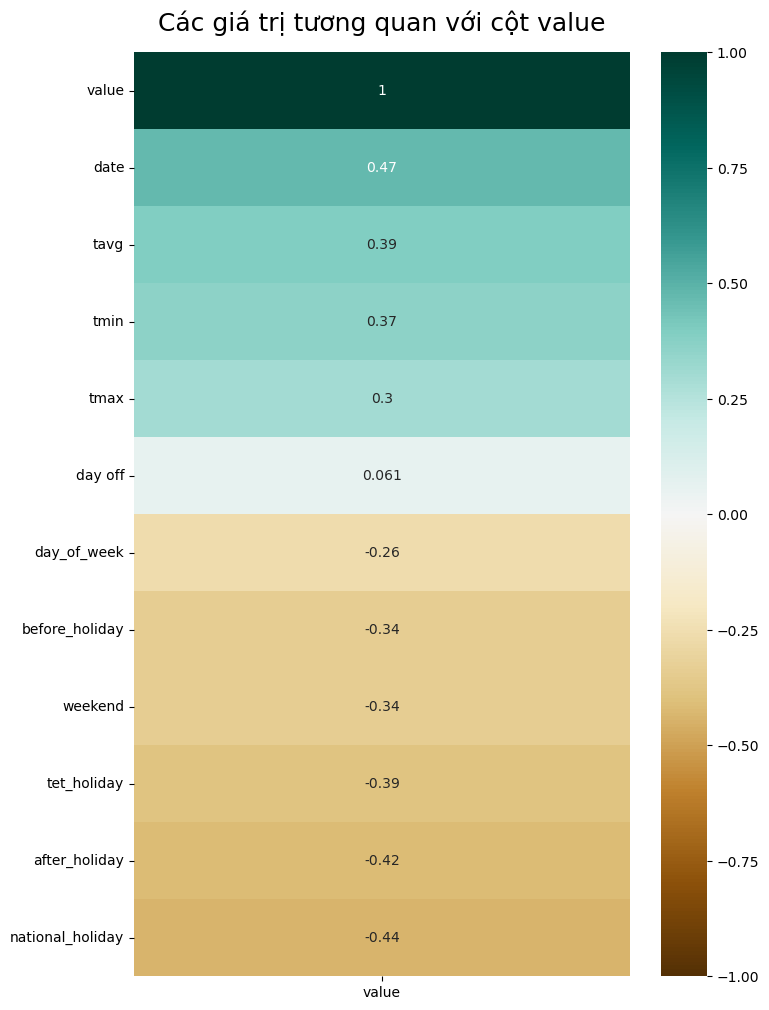

In [230]:
correlation_matrix = df_final.corr()
# Lấy độ tương quan của tất cả các cột với cột 'value'
value_correlation = correlation_matrix[['value']].sort_values(by='value', ascending=False)

# In ra màn hình các giá trị tương quan với cột 'value'
print(value_correlation)

# Trực quan hóa các giá trị tương quan bằng heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(value_correlation, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Các giá trị tương quan với cột value', fontdict={'fontsize':18}, pad=16)
plt.show()

# Đào tạo mô hình Long Short Term Memory

In [231]:
data = pd.read_csv('data/data_clean_v0.csv', index_col='date', parse_dates=True)
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(10)

,day_of_week,value,day off,national_holiday,weekend,before_holiday,after_holiday,tet_holiday,tavg,tmin,tmax
date,,,,,,,,,,,
2021-01-01,4,0.205042,1,1,0,0,0,0,0.21,0.416667,0.250000
2021-01-02,5,0.332894,0,0,1,0,1,0,0.32,0.333333,0.333333
2021-01-03,6,0.348436,0,0,1,0,0,0,0.43,0.333333,0.416667
2021-01-04,0,0.579010,0,0,0,0,0,0,0.48,0.500000,0.500000
2021-01-05,1,0.642650,0,0,0,0,0,0,0.46,0.500000,0.416667
2021-01-06,2,0.646798,1,0,0,0,0,0,0.51,0.500000,0.416667
2021-01-07,3,0.643539,1,0,0,0,0,0,0.51,0.500000,0.583333
2021-01-08,4,0.647141,0,0,0,0,0,0,0.46,0.500000,0.500000
2021-01-09,5,0.588349,0,0,1,0,0,0,0.39,0.416667,0.416667


In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1369 entries, 2021-01-01 to 2024-09-30
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   day_of_week       1369 non-null   int64  
 1   value             1369 non-null   float64
 2   day off           1369 non-null   int64  
 3   national_holiday  1369 non-null   int64  
 4   weekend           1369 non-null   int64  
 5   before_holiday    1369 non-null   int64  
 6   after_holiday     1369 non-null   int64  
 7   tet_holiday       1369 non-null   int64  
 8   tavg              1369 non-null   float64
 9   tmin              1369 non-null   float64
 10  tmax              1369 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 128.3 KB


In [233]:
data.describe()

,day_of_week,value,day off,national_holiday,weekend,before_holiday,after_holiday,tet_holiday,tavg,tmin,tmax
count,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000
mean,3.002191,0.649714,0.308985,0.032140,0.286340,0.031410,0.032140,0.016070,0.560044,0.607859,0.518523
std,2.002008,0.170376,0.462244,0.176437,0.452216,0.174486,0.176437,0.125791,0.146351,0.135373,0.152928
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.571889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.460000,0.500000,0.416667
50%,3.000000,0.686307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.560000,0.583333,0.500000
75%,5.000000,0.758537,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.660000,0.666667,0.666667
max,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [234]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LeakyReLU# type: ignore
from sklearn.model_selection import train_test_split # type: ignore
import tensorflow as tf # type: ignore 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from fsspec import Callback # type: ignore 
from sklearn.metrics import mean_squared_error
from tensorflow.keras.regularizers import l2 # type: ignore
import math

In [235]:
# Định nghĩa hàm tạo chuỗi dữ liệu cho LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, -1]) 
    return np.array(X), np.array(y)

In [236]:
# Tạo mảng dữ liệu cho LSTM
data_values = data[['day_of_week','day off','tavg', 'tmin', 'tmax', 'value']].values
time_step = 7  # Bạn có thể thay đổi giá trị này
X, y = create_dataset(data_values, time_step)

# Chia dữ liệu thành tập huấn luyện, tập validation và tập kiểm tra
train_size = int(len(X) * 0.70)  # 80% dữ liệu cho tập huấn luyện
val_size = int(len(X) * 0.20)    # 10% dữ liệu cho tập validation
test_size = len(X) - train_size - val_size  # Còn lại cho tập kiểm tra

# Chia tập dữ liệu
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Chuyển dữ liệu thành dạng 3D cho LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_lstm = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [237]:
# Hàm tạo mô hình LSTM với Bidirectional và Regularization
def create_improved_model(units=128, optimizer='adam', dropout_rate=0.5, l2_rate=0.05):
    model = Sequential()

    # Thêm Bidirectional LSTM với regularization
    model.add(Bidirectional(LSTM(units=units, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), 
                                 kernel_regularizer=l2(l2_rate))))
    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(units=units, return_sequences=False, 
                                 kernel_regularizer=l2(l2_rate))))
    model.add(Dropout(dropout_rate))

    # Thay đổi hàm kích hoạt
    model.add(Dense(64, activation='relu'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1))  # Tầng đầu ra

    # Compile mô hình
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Tạo mô hình với các thông số tùy chỉnh
model = create_improved_model(units=256, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), dropout_rate=0.5)

d:\Install App\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

d:\Install App\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



In [238]:
from tensorflow.keras.callbacks import Callback
import numpy as np
from sklearn.metrics import mean_squared_error

class RMSECallback(Callback):
    def __init__(self, X_test, y_test):
        super(RMSECallback, self).__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.rmse_history = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_test)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        self.rmse_history.append(rmse)
        print(f'\nEpoch {epoch + 1}: RMSE = {rmse:.4f}')


In [239]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# checkpoint = ModelCheckpoint('model/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

In [240]:
# Initialize RMSE callback
rmse_callback = RMSECallback(X_test_lstm, y_test)

# Train the model with the callback
history = model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), 
                    epochs=20, batch_size=64, callbacks=[early_stop, rmse_callback])

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/stepp - loss: 64.

Epoch 1: RMSE = 0.1204
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - loss: 64.1126 - val_loss: 48.3164
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step ep - loss: 44.268

Epoch 2: RMSE = 0.1827
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 44.0319 - val_loss: 32.3526
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step ep - loss: 29.462

Epoch 3: RMSE = 0.2048
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 29.2960 - val_loss: 21.1287
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step ep - loss: 19.147

Epoch 4: RMSE = 0.2001
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 19.0346 - val_loss: 13.5100
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step ep - loss: 12.188

Epoch 5: RMSE = 0.1690
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 12.1136 - val_loss: 8.4620
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step ep - loss: 7.605

Epoch 6: RMSE = 0.2161
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.5571 - val_loss: 5.2066
Epoch 7/2

In [241]:
# Tạo biểu đồ
fig = go.Figure()

# Thêm trace cho Training Loss
fig.add_trace(go.Scatter(x=list(range(len(history.history['loss']))), 
                         y=history.history['loss'], 
                         mode='lines+markers', 
                         name='Training Loss'))

# Thêm trace cho Validation Loss
fig.add_trace(go.Scatter(x=list(range(len(history.history['val_loss']))), 
                         y=history.history['val_loss'], 
                         mode='lines+markers', 
                         name='Validation Loss'))

# Thiết lập tiêu đề và nhãn
fig.update_layout(
    title='Loss During Training',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend_title='Legend',
    template='plotly_white'
)

# Hiển thị biểu đồ
fig.show()

In [242]:
import plotly.graph_objects as go

# Tạo biểu đồ cho RMSE
fig = go.Figure()

# Thêm trace cho RMSE
fig.add_trace(go.Scatter(x=list(range(len(rmse_callback.rmse_history))), 
                         y=rmse_callback.rmse_history, 
                         mode='lines+markers', 
                         name='RMSE on Test Data'))

# Thiết lập tiêu đề và nhãn
fig.update_layout(
    title='RMSE During Training',
    xaxis_title='Epochs',
    yaxis_title='RMSE',
    legend_title='Legend',
    template='plotly_white'
)

# Hiển thị biểu đồ
fig.show()


In [243]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_lstm)

# Tải lại scaler để inverse_transform
scaler = joblib.load('model/minmax_scaler.pkl')

# Sử dụng inverse_transform cho cả giá trị thực và giá trị dự đoán
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 3)), y_pred), axis=1))[:, -1]

# Làm tròn kết quả thành số nguyên
y_test_inverse = np.round(y_test_inverse).astype(int)
y_pred_inverse = np.round(y_pred_inverse).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [244]:
# Load ánh xạ đã lưu
loaded_mapping = load('model/day_mapping.joblib')
# Hàm chuẩn hóa ngược cho toàn bộ cột dữ liệu
def inverse_mapping_all(numbers):
    inverse_map = {v: k for k, v in loaded_mapping.items()}
    return [inverse_map.get(num, None) for num in numbers]

# Thực hiện chuẩn hóa ngược cho toàn bộ cột 'Thứ số'
data['day_of_week'] = inverse_mapping_all(data['day_of_week'])

In [245]:
# Tải lại scaler đã lưu
scaler = joblib.load('model/minmax_scaler.pkl')

# Nghịch đảo chuẩn hóa cho các cột 'tavg', 'tmin', 'tmax', 'value'
X_test_lstm_2d = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1] * X_test_lstm.shape[2]))

label_encoder = joblib.load('label_encoder/Thứ_labelencoder.pkl')
# Kiểm tra các nhãn trong df['Thứ'] và chỉ giữ lại những nhãn đã thấy
known_labels = label_encoder.classes_
df_filtered = df[df['Thứ'].isin(known_labels)]

# Chuyển đổi các nhãn đã thấy
df_filtered['Thứ'] = label_encoder.inverse_transform(df_filtered['Thứ'])

# Xây dựng DataFrame kết quả cho các giá trị thực và dự đoán
date_test = data.index[-len(X_test):]
results_df = pd.DataFrame({
    'date': date_test,
    'day_of_week': data['day_of_week'][-len(y_test):].values,
    'actual': y_test_inverse,  # Giá trị thực đã được inverse_transform
    'predicted': y_pred_inverse  # Giá trị dự đoán đã được inverse_transform
})

In [246]:


# Vẽ biểu đồ so sánh giá trị thực và dự đoán
fig = go.Figure()

# Thêm dữ liệu thực
fig.add_trace(go.Scatter(
    x=results_df['date'],
    y=results_df['actual'],
    mode='lines',
    name='Giá trị thực',
    line=dict(color='blue')
))

# Thêm dữ liệu dự đoán
fig.add_trace(go.Scatter(
    x=results_df['date'],
    y=results_df['predicted'],
    mode='lines',
    name='Giá trị dự đoán',
    line=dict(color='red')
))

# Cài đặt tiêu đề và nhãn
fig.update_layout(
    title='So sánh giữa giá trị thực và giá trị dự đoán',
    xaxis_title='Ngày',
    yaxis_title='Giá trị',
    legend=dict(x=0, y=1),
    xaxis_rangeslider_visible=True
)

# Hiển thị biểu đồ
fig.show()

In [247]:
results_df.to_csv('data/predict_data.csv')

In [248]:
model.save('model/lstm_model.h5')

## Tải lại mô hình đã lưu

In [249]:
# Tải lại model đã lưu
loaded_model = tf.keras.models.load_model('model/lstm_model.h5')


# Tranfomer

In [250]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Chuẩn bị dữ liệu như trong ví dụ LSTM
data = pd.read_csv('data/data_clean_v0.csv')

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
data[['tavg', 'tmin', 'tmax', 'value']] = scaler.fit_transform(data[['tavg', 'tmin', 'tmax', 'value']])
joblib.dump(scaler, 'model/minmax_scaler.pkl')

# Tạo dataset cho Transformer
def create_dataset(data, time_step=7):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Tất cả các đặc trưng
        y.append(data[i + time_step, -1])  # Cột 'value'
    return np.array(X), np.array(y)

data_np = data.drop(columns=['value', 'date', 'day_of_week']).values
X, y = create_dataset(data_np, time_step=7)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.93)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Xây dựng Transformer Encoder
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Xây dựng mô hình dự báo Transformer
def create_transformer_model(time_steps, num_features, embed_dim=64, num_heads=2, ff_dim=128, dropout_rate=0.1):
    inputs = tf.keras.layers.Input(shape=(time_steps, num_features))
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    # Gọi transformer_block với tham số training
    x = transformer_block(inputs, training=True)  # Cập nhật ở đây
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")
    return model

# Tạo mô hình Transformer
time_steps = X_train.shape[1]
num_features = X_train.shape[2]
model = create_transformer_model(time_steps, num_features)

# Huấn luyện mô hình
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/best_transformer_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=200, batch_size=64, callbacks=[early_stop, checkpoint])

# Dự đoán và đánh giá kết quả
y_pred = model.predict(X_test)

# Tải lại scaler đã lưu
scaler = joblib.load('model/minmax_scaler.pkl')

# Sử dụng inverse_transform cho cả giá trị thực và giá trị dự đoán
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 3)), y_pred), axis=1))[:, -1]

# Hiển thị kết quả
import plotly.graph_objects as go

results_df = pd.DataFrame({
    'actual': y_test_inverse,
    'predicted': y_pred_inverse
})

fig = go.Figure()

fig.add_trace(go.Scatter(y=results_df['actual'], mode='lines', name='Giá trị thực', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=results_df['predicted'], mode='lines', name='Giá trị dự đoán', line=dict(color='red')))

fig.update_layout(title='So sánh giá trị thực và giá trị dự đoán', xaxis_title='Index', yaxis_title='Giá trị')
fig.show()


d:\Install App\anaconda3\Lib\site-packages\keras\src\layers\layer.py:1331: UserWarning:

Layer 'transformer_block_5' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Dimensions must be equal, but are 10 and 64 for '{{node add_1}} = AddV2[T=DT_FLOAT](layer_normalization_10_1/add_2, dropout_30_1/stateless_dropout/SelectV2)' with input shapes: [?,7,10], [?,7,64].''

d:\Install App\anaconda3\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning:

`build()` 

ValueError: Exception encountered when calling TransformerBlock.call().

[1mCould not automatically infer the output shape / dtype of 'transformer_block_5' (of type TransformerBlock). Either the `TransformerBlock.call()` method is incorrect, or you need to implement the `TransformerBlock.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 10 and 64 for '{{node add_1}} = AddV2[T=DT_FLOAT](layer_normalization_10_1/add_2, dropout_30_1/stateless_dropout/SelectV2)' with input shapes: [?,7,10], [?,7,64].[0m

Arguments received by TransformerBlock.call():
  • args=('<KerasTensor shape=(None, 7, 10), dtype=float32, sparse=None, name=keras_tensor_236>',)
  • kwargs={'training': 'True'}

# Temporal Convolutional Network

In [273]:
data = pd.read_csv('data/data_clean_v0.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [274]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Chuẩn bị dữ liệu chuỗi thời gian như trước đó
date_column = data['date']
day_of_week_column = data['day_of_week']
data_np = data.drop(columns=['value', 'date', 'day_of_week']).values

# Hàm tạo dataset cho TCN
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :-1])
        y.append(data[i + time_step - 1, -1])
    return np.array(X), np.array(y)

# Chia dữ liệu thành đầu vào (X) và đầu ra (y)
X, y = create_dataset(data_np, time_step=7)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Thêm một chiều cho dữ liệu để phù hợp với Transformer (batch_size, sequence_length, num_features)
X_train = np.expand_dims(X_train, axis=0)
X_test = np.expand_dims(X_test, axis=0)

In [275]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention

# Hàm xây dựng mô hình Transformer
def create_transformer_model(input_shape, num_heads=8, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Lớp MultiHeadAttention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention)
    
    # Lớp Feed-Forward
    ff_output = Dense(ff_dim, activation='relu')(attention)
    ff_output = Dense(input_shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attention)  # Residual connection
    
    # Dự đoán
    outputs = Dense(1)(ff_output)
    
    # Tạo mô hình
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    return model

# Khởi tạo mô hình Transformer
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_transformer_model(input_shape)

# Kiểm tra kiến trúc của mô hình
model.summary()


Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1089, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1089, 7)   │      1,743 │ input_layer_15[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 1089, 7)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1089, 7)   │         14 │ dropout_31[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1089, 128) │      1,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1089, 7)   │        903 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 1089, 7)   │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1089, 7)   │          0 │ dropout_32[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1089, 7)   │         14 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1089, 1)   │          8 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,706 (14.48 KB)

 Trainable params: 3,706 (14.48 KB)

 Non-trainable params: 0 (0.00 B)

In [276]:
# Thiết lập EarlyStopping và ModelCheckpoint
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/best_transformer_model.keras', save_best_only=True)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1
'y' sizes: 1089


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Biến đổi ngược scaler
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 3)), y_pred), axis=1))[:, -1]

# So sánh giá trị thực và dự đoán
results_df = pd.DataFrame({
    'date': date_column.iloc[len(data) - len(X_test):].values,
    'day_of_week': day_of_week_column.iloc[len(data) - len(X_test):].values,
    'actual': y_test_inverse,
    'predicted': y_pred_inverse
})

# Hiển thị kết quả dự đoán
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_df['date'],
    y=results_df['actual'],
    mode='lines',
    name='Giá trị thực',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=results_df['date'],
    y=results_df['predicted'],
    mode='lines',
    name='Giá trị dự đoán',
    line=dict(color='red')
))

fig.update_layout(
    title='So sánh giá trị thực và giá trị dự đoán',
    xaxis_title='Ngày',
    yaxis_title='Giá trị',
    legend=dict(x=0, y=1),
    xaxis_rangeslider_visible=True
)

fig.show()
